# Hand Gesture Recognition với Neural Network

Notebook này hướng dẫn xây dựng và training một neural network model để nhận dạng cử chỉ tay sử dụng hand landmarks từ MediaPipe.

## Mục tiêu:
- Load và khám phá dataset hand gesture 
- Tiền xử lý dữ liệu hand landmarks
- Xây dựng neural network architecture
- Training model với TensorFlow/Keras
- Đánh giá hiệu suất model
- Convert sang TensorFlow Lite để deploy
- Test inference với model đã train

## 1. Import Required Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("TensorFlow version:", tf.__version__)
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)

TensorFlow version: 2.19.0
Pandas version: 2.3.1
NumPy version: 1.26.4


## 2. Load và Explore Dataset

In [2]:
# Đường dẫn đến dataset
dataset_path = 'dataset/hand_gestures_dataset.csv'

# Load dataset
print("Loading dataset...")
df = pd.read_csv(dataset_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nGesture distribution:")
print(df['gesture_name'].value_counts())

print("\nHand type distribution:")
print(df['hand_0_type'].value_counts())

print("\nNumber of hands distribution:")
print(df['num_hands'].value_counts())

Loading dataset...
Dataset shape: (463, 90)
Columns: 90

First few rows:
                timestamp  class_id gesture_name  num_hands hand_0_type  \
0  20250807_161032_401448         2          two          1        Left   
1  20250807_161033_963409         2          two          1        Left   
2  20250807_161034_845662         2          two          2        Left   
3  20250807_161035_492472         2          two          1        Left   
4  20250807_161035_995513         2          two          1        Left   

   hand_0_landmark_0_x  hand_0_landmark_0_y  hand_0_landmark_1_x  \
0                  141                  418                  189   
1                  173                  455                  220   
2                  288                  417                  326   
3                  375                  464                  433   
4                  425                  456                  481   

   hand_0_landmark_1_y  hand_0_landmark_2_x  ...  hand_1_landmark_1

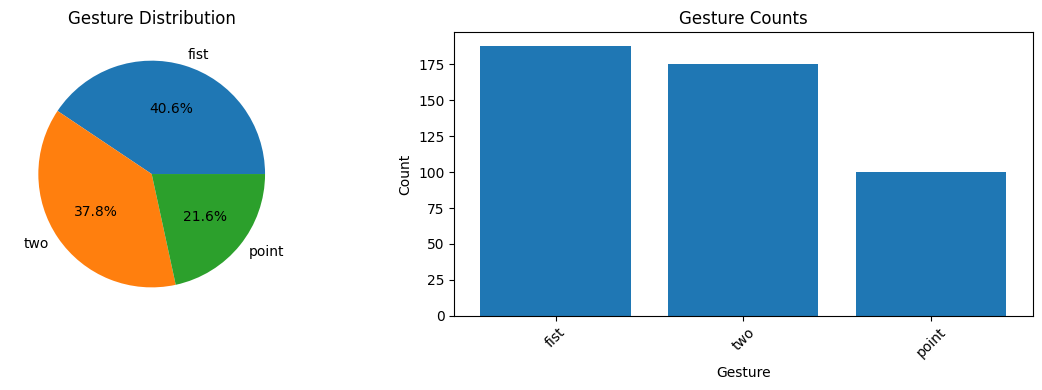


Dataset Summary:
Total samples: 463
Number of gestures: 3
Gesture classes: ['two', 'fist', 'point']
Missing values: 18705


In [3]:
# Visualize gesture distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
gesture_counts = df['gesture_name'].value_counts()
plt.pie(gesture_counts.values, labels=gesture_counts.index, autopct='%1.1f%%')
plt.title('Gesture Distribution')

plt.subplot(1, 2, 2)
plt.bar(gesture_counts.index, gesture_counts.values)
plt.title('Gesture Counts')
plt.xlabel('Gesture')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"\nDataset Summary:")
print(f"Total samples: {len(df)}")
print(f"Number of gestures: {df['gesture_name'].nunique()}")
print(f"Gesture classes: {list(df['gesture_name'].unique())}")
print(f"Missing values: {df.isnull().sum().sum()}")

## 3. Data Preprocessing

Xử lý dữ liệu để chuẩn bị cho việc training model. Chúng ta sẽ:
- Lọc ra chỉ các sample có 1 tay (đơn giản hóa)
- Extract tọa độ x,y của 21 landmarks
- Normalize dữ liệu
- Encode labels

In [4]:
# Filter data - chỉ lấy samples có 1 tay để đơn giản
df_filtered = df[df['num_hands'] == 1].copy()
print(f"Filtered dataset shape: {df_filtered.shape}")
print(f"Remaining gestures: {df_filtered['gesture_name'].value_counts()}")

# Tạo function để extract hand landmarks
def extract_hand_landmarks(row):
    """Extract x,y coordinates of 21 hand landmarks"""
    landmarks = []
    
    # Extract 21 landmarks (0-20) for hand_0
    for i in range(21):
        x_col = f'hand_0_landmark_{i}_x'
        y_col = f'hand_0_landmark_{i}_y'
        
        if x_col in row and y_col in row:
            landmarks.extend([row[x_col], row[y_col]])
        else:
            # Fill missing landmarks with 0
            landmarks.extend([0.0, 0.0])
    
    return np.array(landmarks)

# Extract features (42 features: 21 landmarks × 2 coordinates)
print("Extracting hand landmarks...")
X_data = []
y_data = []

for idx, row in df_filtered.iterrows():
    landmarks = extract_hand_landmarks(row)
    if len(landmarks) == 42:  # Ensure we have all 21 landmarks
        X_data.append(landmarks)
        y_data.append(row['gesture_name'])

X_data = np.array(X_data)
y_data = np.array(y_data)

print(f"Feature matrix shape: {X_data.shape}")
print(f"Labels shape: {y_data.shape}")
print(f"Feature range - min: {X_data.min():.2f}, max: {X_data.max():.2f}")

Filtered dataset shape: (435, 90)
Remaining gestures: gesture_name
fist     184
two      157
point     94
Name: count, dtype: int64
Extracting hand landmarks...
Feature matrix shape: (435, 42)
Labels shape: (435,)
Feature range - min: -13.00, max: 691.00


## 4. Feature Engineering và Normalization

Normalized feature range - min: 0.00, max: 1.00
Original labels: ['fist' 'point' 'two']
Encoded labels: [0 1 2]
Number of classes: 3
Scaler and label encoder saved!


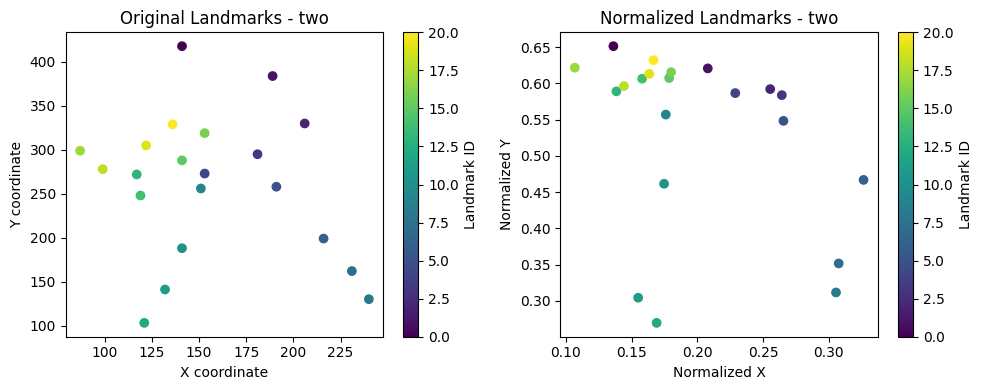

In [6]:
# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_data)

print(f"Normalized feature range - min: {X_normalized.min():.2f}, max: {X_normalized.max():.2f}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_data)

print(f"Original labels: {label_encoder.classes_}")
print(f"Encoded labels: {np.unique(y_encoded)}")
print(f"Number of classes: {len(label_encoder.classes_)}")

# Save scaler and label encoder for later use
os.makedirs('model/neural_network', exist_ok=True)

with open('model/neural_network/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('model/neural_network/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("Scaler and label encoder saved!")

# Visualize a sample of landmarks
plt.figure(figsize=(10, 4))

# Plot original vs normalized features for first sample
sample_idx = 0
original_landmarks = X_data[sample_idx].reshape(21, 2)
normalized_landmarks = X_normalized[sample_idx].reshape(21, 2)

plt.subplot(1, 2, 1)
plt.scatter(original_landmarks[:, 0], original_landmarks[:, 1], c=range(21), cmap='viridis')
plt.title(f'Original Landmarks - {y_data[sample_idx]}')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.colorbar(label='Landmark ID')

plt.subplot(1, 2, 2)
plt.scatter(normalized_landmarks[:, 0], normalized_landmarks[:, 1], c=range(21), cmap='viridis')
plt.title(f'Normalized Landmarks - {y_data[sample_idx]}')
plt.xlabel('Normalized X')
plt.ylabel('Normalized Y')
plt.colorbar(label='Landmark ID')

plt.tight_layout()
plt.show()

## 5. Train-Test Split

In [7]:
# Split data into train and test sets
try:
    # Try stratified split first
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y_encoded, 
        test_size=0.25, 
        random_state=RANDOM_SEED,
        stratify=y_encoded
    )
    print("Using stratified split")
except ValueError as e:
    print(f"Stratified split failed: {e}")
    print("Using simple random split")
    # Fallback to simple random split
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y_encoded, 
        test_size=0.25, 
        random_state=RANDOM_SEED
    )

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

# Check class distribution in train and test sets
print("\nClass distribution in training set:")
train_unique, train_counts = np.unique(y_train, return_counts=True)
for cls, count in zip(train_unique, train_counts):
    gesture_name = label_encoder.inverse_transform([cls])[0]
    print(f"  {gesture_name} (class {cls}): {count} samples")

print("\nClass distribution in test set:")
test_unique, test_counts = np.unique(y_test, return_counts=True)
for cls, count in zip(test_unique, test_counts):
    gesture_name = label_encoder.inverse_transform([cls])[0]
    print(f"  {gesture_name} (class {cls}): {count} samples")

Using stratified split
Training set shape: (326, 42)
Test set shape: (109, 42)
Training labels shape: (326,)
Test labels shape: (109,)

Class distribution in training set:
  fist (class 0): 138 samples
  point (class 1): 70 samples
  two (class 2): 118 samples

Class distribution in test set:
  fist (class 0): 46 samples
  point (class 1): 24 samples
  two (class 2): 39 samples


## 6. Model Architecture Setup

Tạo neural network architecture dựa trên project mẫu, được điều chỉnh cho dataset của chúng ta.

In [8]:
# Define model parameters
INPUT_SIZE = 42  # 21 landmarks × 2 coordinates
NUM_CLASSES = len(label_encoder.classes_)

print(f"Input size: {INPUT_SIZE}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {label_encoder.classes_}")

# Build neural network model (based on the sample project)
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((INPUT_SIZE,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Display model architecture
model.summary()

# Visualize model architecture
tf.keras.utils.plot_model(
    model, 
    to_file='model/neural_network/model_architecture.png',
    show_shapes=True, 
    show_layer_names=True,
    dpi=96
)

print("Model architecture saved as model_architecture.png")

Input size: 42
Number of classes: 3
Classes: ['fist' 'point' 'two']


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,103 (4.31 KB)

 Trainable params: 1,103 (4.31 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.
Model architecture saved as model_architecture.png


## 7. Model Training

In [9]:
# Define paths for saving model
model_save_path = 'model/neural_network/hand_gesture_model.h5'
checkpoint_path = 'model/neural_network/checkpoints/hand_gesture_model.h5'

# Create directories
os.makedirs('model/neural_network/checkpoints', exist_ok=True)

# Define callbacks
callbacks = [
    # Model checkpoint - save best model
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    # Early stopping - stop training if no improvement
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        verbose=1,
        restore_best_weights=True
    ),
    # Reduce learning rate on plateau
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        verbose=1,
        min_lr=1e-7
    )
]

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print("Starting training...")

Model compiled successfully!
Starting training...


Epoch 1/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 9s 929ms/step - accuracy: 0.3125 - loss: 1.1131
Epoch 1: val_accuracy improved from None to 0.40367, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3773 - loss: 1.0934 - val_accuracy: 0.4037 - val_loss: 1.0790 - learning_rate: 0.0010
Epoch 2/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3750 - loss: 1.1197
Epoch 2: val_accuracy improved from 0.40367 to 0.44037, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3742 - loss: 1.0853 - val_accuracy: 0.4404 - val_loss: 1.0750 - learning_rate: 0.0010
Epoch 3/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3438 - loss: 1.1224
Epoch 3: val_accuracy improved from 0.44037 to 0.47706, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4325 - loss: 1.0835 - val_accuracy: 0.4771 - val_loss: 1.0714 - learning_rate: 0.0010
Epoch 4/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3125 - loss: 1.1043
Epoch 4: val_accuracy improved from 0.47706 to 0.50459, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4080 - loss: 1.0816 - val_accuracy: 0.5046 - val_loss: 1.0671 - learning_rate: 0.0010
Epoch 5/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3125 - loss: 1.0980
Epoch 5: val_accuracy improved from 0.50459 to 0.53211, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4172 - loss: 1.0655 - val_accuracy: 0.5321 - val_loss: 1.0601 - learning_rate: 0.0010
Epoch 6/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4062 - loss: 1.0794
Epoch 6: val_accuracy did not improve from 0.53211
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4693 - loss: 1.0617 - val_accuracy: 0.5138 - val_loss: 1.0520 - learning_rate: 0.0010
Epoch 7/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4375 - loss: 1.1032
Epoch 7: val_accuracy did not improve from 0.53211
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5061 - loss: 1.0425 - val_accuracy: 0.5138 - val_loss: 1.0347 - learning_rate: 0.0010
Epoch 8/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5000 - loss: 1.0612
Epoch 8: val_accuracy improved from 0.53211 to 0.55046, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5184 - loss: 1.0348 - val_accuracy: 0.5505 - val_loss: 1.0082 - learning_rate: 0.0010
Epoch 9/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4688 - loss: 1.0250
Epoch 9: val_accuracy improved from 0.55046 to 0.60550, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5276 - loss: 1.0106 - val_accuracy: 0.6055 - val_loss: 0.9739 - learning_rate: 0.0010
Epoch 10/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4688 - loss: 1.0210
Epoch 10: val_accuracy did not improve from 0.60550
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5368 - loss: 0.9922 - val_accuracy: 0.5963 - val_loss: 0.9466 - learning_rate: 0.0010
Epoch 11/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4688 - loss: 1.0486
Epoch 11: val_accuracy did not improve from 0.60550
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5613 - loss: 0.9758 - val_accuracy: 0.6055 - val_loss: 0.9184 - learning_rate: 0.0010
Epoch 12/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4375 - loss: 0.9832
Epoch 12: val_accuracy did not improve from 0.60550
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5736 - loss: 0.9474 - val_accuracy: 0.5963 - val_loss: 0.8933 - learning_rate: 0.0010
Epoch 13/1000
 1/11 ━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6043 - loss: 0.9220 - val_accuracy: 0.6606 - val_loss: 0.8550 - learning_rate: 0.0010
Epoch 15/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5625 - loss: 0.9635
Epoch 15: val_accuracy improved from 0.66055 to 0.67890, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6135 - loss: 0.9012 - val_accuracy: 0.6789 - val_loss: 0.8315 - learning_rate: 0.0010
Epoch 16/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5000 - loss: 1.0760
Epoch 16: val_accuracy improved from 0.67890 to 0.70642, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6104 - loss: 0.9226 - val_accuracy: 0.7064 - val_loss: 0.8111 - learning_rate: 0.0010
Epoch 17/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5625 - loss: 0.9711
Epoch 17: val_accuracy improved from 0.70642 to 0.71560, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6012 - loss: 0.9225 - val_accuracy: 0.7156 - val_loss: 0.7961 - learning_rate: 0.0010
Epoch 18/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5312 - loss: 1.0096
Epoch 18: val_accuracy improved from 0.71560 to 0.72477, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6074 - loss: 0.8956 - val_accuracy: 0.7248 - val_loss: 0.7782 - learning_rate: 0.0010
Epoch 19/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6562 - loss: 0.8970
Epoch 19: val_accuracy improved from 0.72477 to 0.73394, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6104 - loss: 0.8811 - val_accuracy: 0.7339 - val_loss: 0.7614 - learning_rate: 0.0010
Epoch 20/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5625 - loss: 0.8925
Epoch 20: val_accuracy improved from 0.73394 to 0.74312, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6534 - loss: 0.8659 - val_accuracy: 0.7431 - val_loss: 0.7418 - learning_rate: 0.0010
Epoch 21/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5312 - loss: 1.0027
Epoch 21: val_accuracy improved from 0.74312 to 0.75229, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6196 - loss: 0.8757 - val_accuracy: 0.7523 - val_loss: 0.7198 - learning_rate: 0.0010
Epoch 22/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5938 - loss: 0.9520
Epoch 22: val_accuracy improved from 0.75229 to 0.76147, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6350 - loss: 0.8598 - val_accuracy: 0.7615 - val_loss: 0.6947 - learning_rate: 0.0010
Epoch 23/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6250 - loss: 0.8222
Epoch 23: val_accuracy did not improve from 0.76147
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6350 - loss: 0.8446 - val_accuracy: 0.7615 - val_loss: 0.6821 - learning_rate: 0.0010
Epoch 24/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5000 - loss: 1.0203
Epoch 24: val_accuracy did not improve from 0.76147
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6748 - loss: 0.8174 - val_accuracy: 0.7615 - val_loss: 0.6668 - learning_rate: 0.0010
Epoch 25/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5938 - loss: 0.9742
Epoch 25: val_accuracy did not improve from 0.76147
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7025 - loss: 0.7836 - val_accuracy: 0.7615 - val_loss: 0.6452 - learning_rate: 0.0010
Epoch 26/1000
 1/11 ━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7055 - loss: 0.7509 - val_accuracy: 0.7706 - val_loss: 0.5693 - learning_rate: 0.0010
Epoch 31/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5625 - loss: 0.9185
Epoch 31: val_accuracy did not improve from 0.77064
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7117 - loss: 0.7544 - val_accuracy: 0.7615 - val_loss: 0.5628 - learning_rate: 0.0010
Epoch 32/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6875 - loss: 0.7729
Epoch 32: val_accuracy did not improve from 0.77064
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7209 - loss: 0.7100 - val_accuracy: 0.7706 - val_loss: 0.5557 - learning_rate: 0.0010
Epoch 33/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6250 - loss: 0.8057
Epoch 33: val_accuracy did not improve from 0.77064
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6933 - loss: 0.7740 - val_accuracy: 0.7706 - val_loss: 0.5301 - learning_rate: 0.0010
Epoch 34/1000
 1/11 ━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6779 - loss: 0.7350 - val_accuracy: 0.7982 - val_loss: 0.5276 - learning_rate: 0.0010
Epoch 35/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7188 - loss: 0.8463
Epoch 35: val_accuracy did not improve from 0.79817
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7209 - loss: 0.7042 - val_accuracy: 0.7982 - val_loss: 0.5243 - learning_rate: 0.0010
Epoch 36/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.9412
Epoch 36: val_accuracy did not improve from 0.79817
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7086 - loss: 0.7391 - val_accuracy: 0.7982 - val_loss: 0.5084 - learning_rate: 0.0010
Epoch 37/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7188 - loss: 0.6572
Epoch 37: val_accuracy improved from 0.79817 to 0.80734, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6963 - loss: 0.7114 - val_accuracy: 0.8073 - val_loss: 0.4998 - learning_rate: 0.0010
Epoch 38/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5938 - loss: 0.8640
Epoch 38: val_accuracy did not improve from 0.80734
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6718 - loss: 0.7565 - val_accuracy: 0.8073 - val_loss: 0.4904 - learning_rate: 0.0010
Epoch 39/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6250 - loss: 0.7151
Epoch 39: val_accuracy improved from 0.80734 to 0.82569, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6810 - loss: 0.7365 - val_accuracy: 0.8257 - val_loss: 0.4879 - learning_rate: 0.0010
Epoch 40/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5312 - loss: 0.8357
Epoch 40: val_accuracy improved from 0.82569 to 0.83486, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6994 - loss: 0.7073 - val_accuracy: 0.8349 - val_loss: 0.4859 - learning_rate: 0.0010
Epoch 41/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7812 - loss: 0.6109
Epoch 41: val_accuracy did not improve from 0.83486
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6963 - loss: 0.6646 - val_accuracy: 0.8165 - val_loss: 0.4691 - learning_rate: 0.0010
Epoch 42/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.7492
Epoch 42: val_accuracy improved from 0.83486 to 0.86239, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7301 - loss: 0.6946 - val_accuracy: 0.8624 - val_loss: 0.4555 - learning_rate: 0.0010
Epoch 43/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6250 - loss: 0.8086
Epoch 43: val_accuracy did not improve from 0.86239
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7178 - loss: 0.6968 - val_accuracy: 0.8624 - val_loss: 0.4609 - learning_rate: 0.0010
Epoch 44/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8438 - loss: 0.5260
Epoch 44: val_accuracy did not improve from 0.86239
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7209 - loss: 0.6637 - val_accuracy: 0.8349 - val_loss: 0.4597 - learning_rate: 0.0010
Epoch 45/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6562 - loss: 0.8252
Epoch 45: val_accuracy did not improve from 0.86239
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7147 - loss: 0.6866 - val_accuracy: 0.8440 - val_loss: 0.4474 - learning_rate: 0.0010
Epoch 46/1000
 1/11 ━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7301 - loss: 0.6720 - val_accuracy: 0.8807 - val_loss: 0.4165 - learning_rate: 0.0010
Epoch 54/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8125 - loss: 0.6793
Epoch 54: val_accuracy did not improve from 0.88073
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7423 - loss: 0.6757 - val_accuracy: 0.8807 - val_loss: 0.4149 - learning_rate: 0.0010
Epoch 55/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5938 - loss: 0.8105
Epoch 55: val_accuracy did not improve from 0.88073
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7485 - loss: 0.6060 - val_accuracy: 0.8440 - val_loss: 0.4022 - learning_rate: 0.0010
Epoch 56/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8438 - loss: 0.5681
Epoch 56: val_accuracy did not improve from 0.88073
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7761 - loss: 0.5829 - val_accuracy: 0.8624 - val_loss: 0.3885 - learning_rate: 0.0010
Epoch 57/1000
 1/11 ━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7117 - loss: 0.6897 - val_accuracy: 0.8991 - val_loss: 0.3926 - learning_rate: 0.0010
Epoch 58/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7812 - loss: 0.5600
Epoch 58: val_accuracy did not improve from 0.89908
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7485 - loss: 0.6246 - val_accuracy: 0.8716 - val_loss: 0.3749 - learning_rate: 0.0010
Epoch 59/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6562 - loss: 0.7867
Epoch 59: val_accuracy did not improve from 0.89908
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7423 - loss: 0.5975 - val_accuracy: 0.8532 - val_loss: 0.3697 - learning_rate: 0.0010
Epoch 60/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6875 - loss: 0.7177
Epoch 60: val_accuracy did not improve from 0.89908
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7638 - loss: 0.5950 - val_accuracy: 0.8716 - val_loss: 0.3637 - learning_rate: 0.0010
Epoch 61/1000
 1/11 ━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7515 - loss: 0.6013 - val_accuracy: 0.9174 - val_loss: 0.3593 - learning_rate: 0.0010
Epoch 62/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8125 - loss: 0.5505
Epoch 62: val_accuracy did not improve from 0.91743
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7914 - loss: 0.5820 - val_accuracy: 0.8991 - val_loss: 0.3581 - learning_rate: 0.0010
Epoch 63/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.6200
Epoch 63: val_accuracy did not improve from 0.91743
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7546 - loss: 0.6124 - val_accuracy: 0.8807 - val_loss: 0.3613 - learning_rate: 0.0010
Epoch 64/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8125 - loss: 0.5258
Epoch 64: val_accuracy did not improve from 0.91743
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7515 - loss: 0.5843 - val_accuracy: 0.8807 - val_loss: 0.3581 - learning_rate: 0.0010
Epoch 65/1000
 1/11 ━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7607 - loss: 0.6057 - val_accuracy: 0.9358 - val_loss: 0.3554 - learning_rate: 0.0010
Epoch 67/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6562 - loss: 0.7055
Epoch 67: val_accuracy did not improve from 0.93578
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7362 - loss: 0.6347 - val_accuracy: 0.9174 - val_loss: 0.3500 - learning_rate: 0.0010
Epoch 68/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7188 - loss: 0.6900
Epoch 68: val_accuracy did not improve from 0.93578
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7546 - loss: 0.6292 - val_accuracy: 0.9083 - val_loss: 0.3528 - learning_rate: 0.0010
Epoch 69/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6250 - loss: 0.7758
Epoch 69: val_accuracy did not improve from 0.93578
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7423 - loss: 0.6107 - val_accuracy: 0.9174 - val_loss: 0.3513 - learning_rate: 0.0010
Epoch 70/1000
 1/11 ━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7883 - loss: 0.5717 - val_accuracy: 0.9541 - val_loss: 0.3443 - learning_rate: 0.0010
Epoch 75/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6875 - loss: 0.7115
Epoch 75: val_accuracy did not improve from 0.95413
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7607 - loss: 0.5963 - val_accuracy: 0.9358 - val_loss: 0.3349 - learning_rate: 0.0010
Epoch 76/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6562 - loss: 0.9458
Epoch 76: val_accuracy did not improve from 0.95413
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7454 - loss: 0.6766 - val_accuracy: 0.9541 - val_loss: 0.3348 - learning_rate: 0.0010
Epoch 77/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7812 - loss: 0.7745
Epoch 77: val_accuracy did not improve from 0.95413
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7577 - loss: 0.5921 - val_accuracy: 0.9450 - val_loss: 0.3369 - learning_rate: 0.0010
Epoch 78/1000
 1/11 ━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7515 - loss: 0.6322 - val_accuracy: 0.9725 - val_loss: 0.3511 - learning_rate: 0.0010
Epoch 82/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7812 - loss: 0.6019
Epoch 82: val_accuracy improved from 0.97248 to 0.98165, saving model to model/neural_network/checkpoints/hand_gesture_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7331 - loss: 0.6084 - val_accuracy: 0.9817 - val_loss: 0.3444 - learning_rate: 0.0010
Epoch 83/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7812 - loss: 0.6131
Epoch 83: val_accuracy did not improve from 0.98165
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7423 - loss: 0.5875 - val_accuracy: 0.9633 - val_loss: 0.3307 - learning_rate: 0.0010
Epoch 84/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7812 - loss: 0.5887
Epoch 84: val_accuracy did not improve from 0.98165
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7945 - loss: 0.5470 - val_accuracy: 0.9725 - val_loss: 0.3227 - learning_rate: 0.0010
Epoch 85/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6562 - loss: 0.5914
Epoch 85: val_accuracy did not improve from 0.98165
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7546 - loss: 0.6674 - val_accuracy: 0.9817 - val_loss: 0.3265 - learning_rate: 0.0010
Epoch 86/1000
 1/11 ━━━

Model saved to model/neural_network/hand_gesture_model.h5


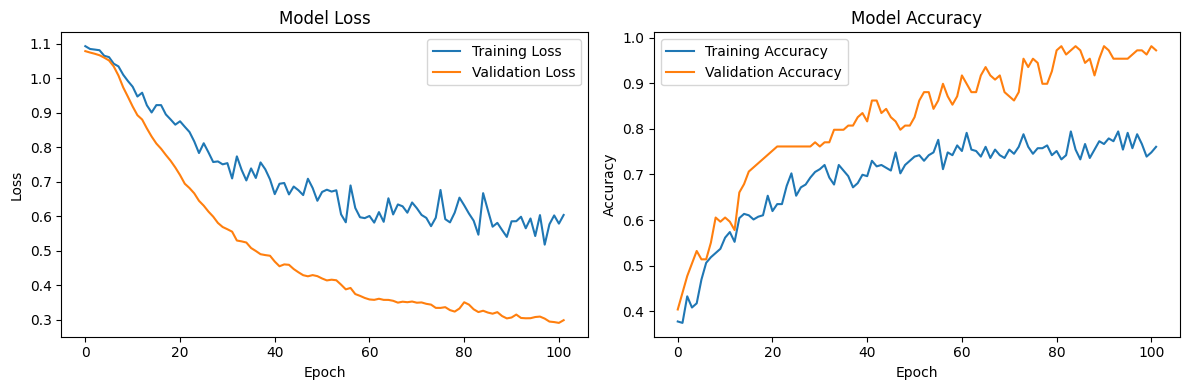


Final Training Results:
Training Loss: 0.6041
Training Accuracy: 0.7607
Validation Loss: 0.2992
Validation Accuracy: 0.9725


In [10]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=min(32, len(X_train)),  # Adjust batch size for small datasets
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

# Save final model
model.save(model_save_path, include_optimizer=False)
print(f"Model saved to {model_save_path}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('model/neural_network/training_history.png')
plt.show()

# Print final training results
final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\nFinal Training Results:")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")

## 8. Model Evaluation

Test Loss: 0.3444
Test Accuracy: 0.9817
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Detailed Test Results:
Accuracy: 0.9817


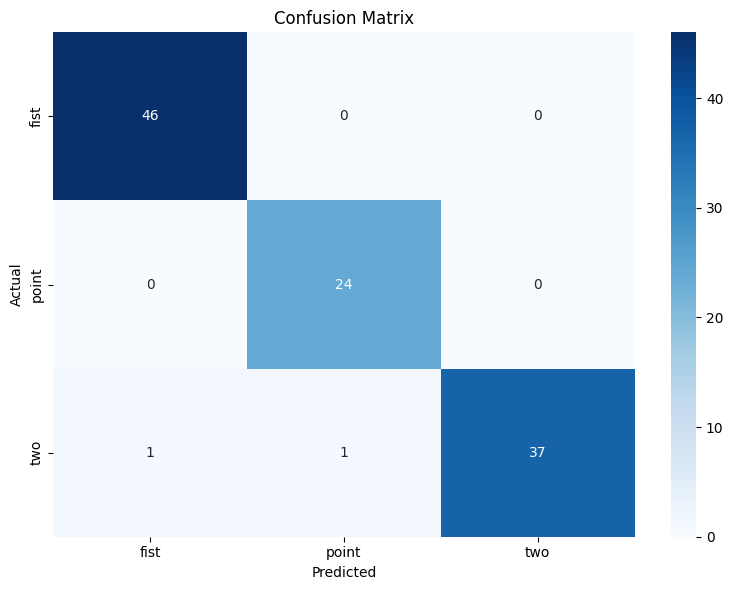


Classification Report:
              precision    recall  f1-score   support

        fist       0.98      1.00      0.99        46
       point       0.96      1.00      0.98        24
         two       1.00      0.95      0.97        39

    accuracy                           0.98       109
   macro avg       0.98      0.98      0.98       109
weighted avg       0.98      0.98      0.98       109


Per-class Results:
fist: Precision=0.979, Recall=1.000, F1=0.989, Support=46.0
point: Precision=0.960, Recall=1.000, F1=0.980, Support=24.0
two: Precision=1.000, Recall=0.949, F1=0.974, Support=39.0

Sample Predictions:
Sample 1: True=fist, Predicted=fist, Confidence=0.663
  Class probabilities:
    fist: 0.663
    point: 0.300
    two: 0.037

Sample 2: True=two, Predicted=two, Confidence=0.794
  Class probabilities:
    fist: 0.012
    point: 0.194
    two: 0.794

Sample 3: True=fist, Predicted=fist, Confidence=0.929
  Class probabilities:
    fist: 0.929
    point: 0.062
    two: 0.009

In [12]:
# Load best model for evaluation
best_model = tf.keras.models.load_model(checkpoint_path)

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_proba = best_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"\nDetailed Test Results:")
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('model/neural_network/confusion_matrix.png')
    plt.show()
    
    return cm

# Plot confusion matrix
cm = plot_confusion_matrix(y_test, y_pred, label_encoder.classes_)

# Classification Report
print("\nClassification Report:")
report = classification_report(y_test, y_pred, 
                             target_names=label_encoder.classes_,
                             output_dict=True)
print(classification_report(y_test, y_pred, 
                          target_names=label_encoder.classes_))

# Per-class accuracy
print("\nPer-class Results:")
for i, class_name in enumerate(label_encoder.classes_):
    if class_name in report:
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        support = report[class_name]['support']
        print(f"{class_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, Support={support}")

# Sample predictions with confidence scores
print("\nSample Predictions:")
for i in range(min(5, len(X_test))):
    true_label = label_encoder.inverse_transform([y_test[i]])[0]
    pred_label = label_encoder.inverse_transform([y_pred[i]])[0]
    confidence = np.max(y_pred_proba[i])
    
    print(f"Sample {i+1}: True={true_label}, Predicted={pred_label}, Confidence={confidence:.3f}")
    
    # Show confidence for all classes
    print("  Class probabilities:")
    for j, class_name in enumerate(label_encoder.classes_):
        prob = y_pred_proba[i][j]
        print(f"    {class_name}: {prob:.3f}")
    print()

## 9. Model Optimization và TensorFlow Lite Conversion

Convert model sang TensorFlow Lite để deploy trên mobile hoặc embedded devices.

In [13]:
# Save model without optimizer for inference
inference_model_path = 'model/neural_network/hand_gesture_inference.h5'
best_model.save(inference_model_path, include_optimizer=False)

# Convert to TensorFlow Lite
tflite_model_path = 'model/neural_network/hand_gesture_model.tflite'

print("Converting model to TensorFlow Lite...")
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

# Apply optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert model
tflite_model = converter.convert()

# Save TFLite model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TensorFlow Lite model saved to {tflite_model_path}")

# Compare model sizes
import os

original_size = os.path.getsize(model_save_path)
tflite_size = os.path.getsize(tflite_model_path)

print(f"\nModel Size Comparison:")
print(f"Original Keras model: {original_size/1024:.2f} KB")
print(f"TensorFlow Lite model: {tflite_size/1024:.2f} KB")
print(f"Size reduction: {((original_size - tflite_size) / original_size) * 100:.1f}%")

# Create a representative dataset for quantization (optional)
def representative_dataset():
    for i in range(min(100, len(X_train))):
        yield [X_train[i:i+1].astype(np.float32)]

# Convert with quantization
print("\nConverting with quantization...")
converter_quantized = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter_quantized.optimizations = [tf.lite.Optimize.DEFAULT]
converter_quantized.representative_dataset = representative_dataset
converter_quantized.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_quantized.inference_input_type = tf.int8
converter_quantized.inference_output_type = tf.int8

tflite_quantized_model = converter_quantized.convert()

# Save quantized model
tflite_quantized_path = 'model/neural_network/hand_gesture_model_quantized.tflite'
with open(tflite_quantized_path, 'wb') as f:
    f.write(tflite_quantized_model)

quantized_size = os.path.getsize(tflite_quantized_path)
print(f"Quantized TensorFlow Lite model: {quantized_size/1024:.2f} KB")
print(f"Additional size reduction: {((tflite_size - quantized_size) / tflite_size) * 100:.1f}%")

Converting model to TensorFlow Lite...
INFO:tensorflow:Assets written to: C:\Users\Dell\AppData\Local\Temp\tmpq4omqaof\assets


INFO:tensorflow:Assets written to: C:\Users\Dell\AppData\Local\Temp\tmpq4omqaof\assets


Saved artifact at 'C:\Users\Dell\AppData\Local\Temp\tmpq4omqaof'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2605477528016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2605477530128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2605477528208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2605477528592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2605477528784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2605477529552: TensorSpec(shape=(), dtype=tf.resource, name=None)
TensorFlow Lite model saved to model/neural_network/hand_gesture_model.tflite

Model Size Comparison:
Original Keras model: 25.66 KB
TensorFlow Lite model: 6.36 KB
Size reduction: 75.2%

Converting with quantization...
INFO:tensorflow:Assets written to: C:\Users\Dell\AppData\Local\Temp\tmp

INFO:tensorflow:Assets written to: C:\Users\Dell\AppData\Local\Temp\tmpdcona8og\assets


Saved artifact at 'C:\Users\Dell\AppData\Local\Temp\tmpdcona8og'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2605477528016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2605477530128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2605477528208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2605477528592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2605477528784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2605477529552: TensorSpec(shape=(), dtype=tf.resource, name=None)
Quantized TensorFlow Lite model: 4.33 KB
Additional size reduction: 31.9%


## 10. Inference Testing

Test các model đã convert với sample data để đảm bảo hoạt động chính xác.

In [14]:
# Test TensorFlow Lite model
def test_tflite_model(model_path, test_sample):
    """Test TensorFlow Lite model inference"""
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], test_sample)
    
    # Run inference
    interpreter.invoke()
    
    # Get output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Test with first test sample
test_sample = X_test[0:1].astype(np.float32)

print("Testing inference on different model formats...")
print(f"Test sample shape: {test_sample.shape}")
print(f"True label: {label_encoder.inverse_transform([y_test[0]])[0]}")

# Original Keras model prediction
keras_pred = best_model.predict(test_sample, verbose=0)
keras_class = np.argmax(keras_pred)
keras_confidence = np.max(keras_pred)

print(f"\nKeras model:")
print(f"  Predicted class: {label_encoder.inverse_transform([keras_class])[0]}")
print(f"  Confidence: {keras_confidence:.4f}")
print(f"  Raw predictions: {keras_pred[0]}")

# TensorFlow Lite model prediction
tflite_pred = test_tflite_model(tflite_model_path, test_sample)
tflite_class = np.argmax(tflite_pred)
tflite_confidence = np.max(tflite_pred)

print(f"\nTensorFlow Lite model:")
print(f"  Predicted class: {label_encoder.inverse_transform([tflite_class])[0]}")
print(f"  Confidence: {tflite_confidence:.4f}")
print(f"  Raw predictions: {tflite_pred[0]}")

# Check if predictions match
predictions_match = np.allclose(keras_pred, tflite_pred, atol=1e-5)
print(f"\nPredictions match: {predictions_match}")
print(f"Max difference: {np.max(np.abs(keras_pred - tflite_pred)):.6f}")

# Benchmark inference speed
import time

def benchmark_model(model_func, test_data, num_runs=100):
    """Benchmark model inference speed"""
    times = []
    for _ in range(num_runs):
        start_time = time.time()
        _ = model_func(test_data)
        times.append(time.time() - start_time)
    
    return np.mean(times), np.std(times)

# Keras model benchmark
def keras_inference(data):
    return best_model.predict(data, verbose=0)

# TensorFlow Lite model benchmark
def tflite_inference(data):
    return test_tflite_model(tflite_model_path, data)

print("\nBenchmarking inference speed (100 runs):")

keras_time, keras_std = benchmark_model(keras_inference, test_sample)
print(f"Keras model: {keras_time*1000:.2f} ± {keras_std*1000:.2f} ms")

tflite_time, tflite_std = benchmark_model(tflite_inference, test_sample)
print(f"TensorFlow Lite: {tflite_time*1000:.2f} ± {tflite_std*1000:.2f} ms")

speedup = keras_time / tflite_time
print(f"Speedup: {speedup:.2f}x")

# Test all test samples
print("\nTesting all test samples...")
correct_keras = 0
correct_tflite = 0

for i in range(len(X_test)):
    sample = X_test[i:i+1].astype(np.float32)
    true_label = y_test[i]
    
    # Keras prediction
    keras_pred = best_model.predict(sample, verbose=0)
    keras_class = np.argmax(keras_pred)
    
    # TFLite prediction  
    tflite_pred = test_tflite_model(tflite_model_path, sample)
    tflite_class = np.argmax(tflite_pred)
    
    if keras_class == true_label:
        correct_keras += 1
    if tflite_class == true_label:
        correct_tflite += 1

keras_accuracy = correct_keras / len(X_test)
tflite_accuracy = correct_tflite / len(X_test)

print(f"Keras model accuracy: {keras_accuracy:.4f}")
print(f"TensorFlow Lite accuracy: {tflite_accuracy:.4f}")
print(f"Accuracy difference: {abs(keras_accuracy - tflite_accuracy):.6f}")

Testing inference on different model formats...
Test sample shape: (1, 42)
True label: fist

Keras model:
  Predicted class: fist
  Confidence: 0.6632
  Raw predictions: [0.6632263  0.29959774 0.03717604]

TensorFlow Lite model:
  Predicted class: fist
  Confidence: 0.6632
  Raw predictions: [0.6632263  0.29959762 0.03717601]

Predictions match: True
Max difference: 0.000000

Benchmarking inference speed (100 runs):
Keras model: 55.65 ± 1.68 ms
TensorFlow Lite: 0.18 ± 0.38 ms
Speedup: 317.41x

Testing all test samples...
Keras model accuracy: 0.9817
TensorFlow Lite accuracy: 0.9817
Accuracy difference: 0.000000
